IT750 Cyber Security -
Course Project

By:
*   Hanumant Mule (202IT014)
*   Namrata Kadam (202IT008)

# Necessary Imports

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, plot_confusion_matrix
#for oversampling minority class
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
import csv

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
#mount google drive to colab notebbok
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset description

The dataset used for this project is Enron-Spam dataset. This dataset is collected from http://www2.aueb.gr/users/ion/data/enron-spam/. We have just used Enron1 folder. It contains two folders of spam and ham. Each folder contains emails. We have iterated to each text file of those folders and created a dataframe and written to a csv file. Dataset can be found here. The Enron1 dataset contains 3672 ham emails and 1499 spam emails. Dataset Classification

# Understanding dataset and preprocessing

In [35]:
#reading email datset which is stored on google drive
data = pd.read_csv('/content/drive/MyDrive/spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [36]:
sample = data.sample(5)
for i in range(5):
    print('Class: ', sample.iloc[i]['label'])
    print('Email:')
    print(sample.iloc[i]['text'])
    print('\n', '---'*45)

Class:  spam
Email:
Subject: lose 19 % weight . a new weightloss is now available .
hello , i have a special offer for you . . .
want to lose weight ?
the most powerful weightloss is now available
without prescription . all natural adipren 720
100 % money back guarant?e !
- lose up to 19 % total body weight .
- loss of 20 - 35 % abdominal fat .
- up to 300 % more weight loss while dieting .
- increase metabolic rate by 76 . 9 % without exercise .
- reduction of 40 - 70 % overall fat under skin .
- suppresses appetite for sugar .
- burns calorized fat .
- boost your confidence level and self esteem .
get the facts about all - natural adipren 720 http : / / adiprenl 2 . com /
- - - - system information - - - -
store natural following xml while correlate calendars version
lists presents interchange organization interested populate source nearly
service for greater specific language yet default policy
purpose stroke - radical group area amended don ' t nearly calendars
expected fallback im

In [37]:
#dropping the ID column as it is of no use in analysis
data.drop('Unnamed: 0', axis = 1, inplace = True)
data.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [38]:
#check and remove null values if any
data.isnull().sum()

label        0
text         0
label_num    0
dtype: int64

In [39]:
#check number of ham and spam mails
data['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

Spam : 3672 Ham : 1499


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Email Class'),
 Text(0.5, 1.0, 'Dataset classification')]

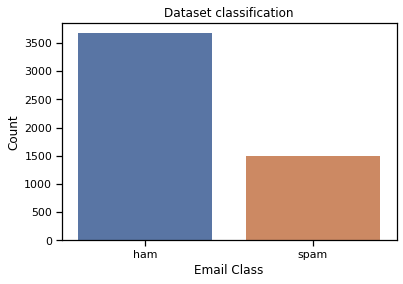

In [40]:
label=['ham','spam']

values=[data['label_num'].value_counts()[0],data['label_num'].value_counts()[1]]
print('Spam : ' +str(values[0]) , 'Ham : ' +str(values[1]) )
ax = sns.barplot(x = label, y = values, data = data)
ax.set(xlabel="Email Class", ylabel = "Count",title='Dataset classification')

Spam email wordcloud


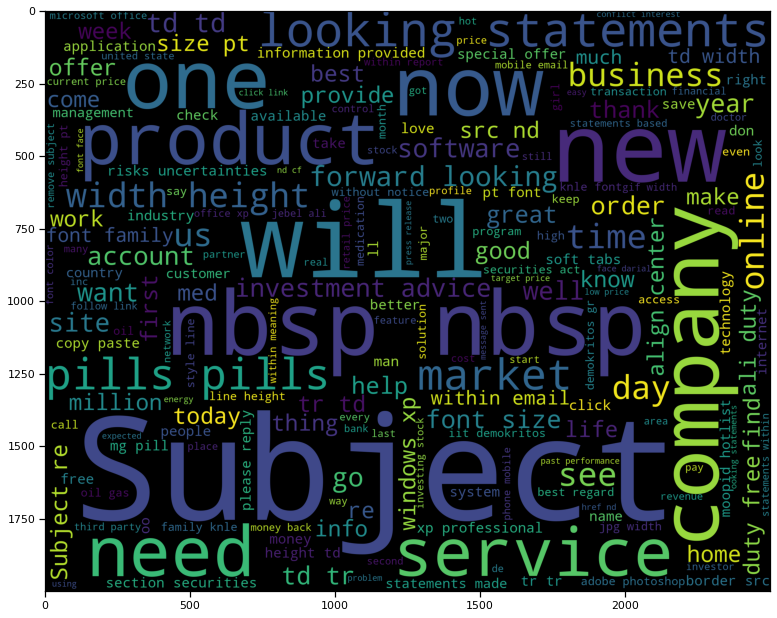

Ham email wordcloud


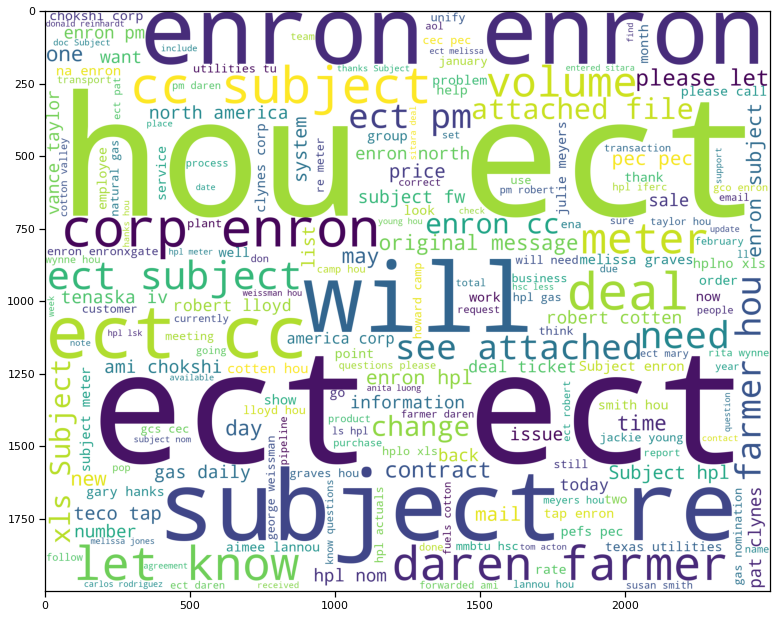

In [41]:
#draw wordcloud
from wordcloud import WordCloud
sns.set(style = None)
train_spam = data[data['label_num'] == 1]
train_spam = train_spam['text']
#turn series to string by join ' ' to it
train_spam = ' '.join(train_spam)
train_ham = data[data['label_num'] == 0]
train_ham = train_ham['text']
train_ham = ' '.join(train_ham)
wordcloud_spam = WordCloud(background_color = 'black', width = 2500, height = 2000 ).generate(train_spam)
plt.figure(figsize = (13,13))
print('Spam email wordcloud')
plt.imshow(wordcloud_spam)
plt.show()
wordcloud_ham = WordCloud(background_color = 'white', width = 2500, height = 2000).generate(train_ham)
print('Ham email wordcloud')
plt.figure(figsize = (13,13))

plt.imshow(wordcloud_ham)
plt.show()

# Feature extraction

Using **TFIDF**



TF-IDF stands for Term Frequency – Inverse Document Frequency

**Term frequency** specifies how frequently a term appears in the entire document.It can be thought of as the probability of finding a word within the document.It calculates the number of times a word occurs in a review , with respect to the total number of words in the review 

The **inverse document frequency** is a measure of whether a term is rare or frequent across the documents in the entire corpus. It highlights those words which occur in very few documents across the corpus, or in simple language, the words that are rare have high IDF score.

In [42]:
#text preprocessing
#indentifying stopwords and removing them
stopwords_set = set(stopwords.words('english'))
stopwords_set.add('subject')
stopwords_set.add('thanks')
stopwords_set.add('cc')
stopwords_set.add('bcc')
stopwords_set.add('please')
stopwords_set.add('http')
stopwords_set.add('aa')


def preprocessing_text(x):
    import string
    #lower case
    x = x.lower()
    #remove number
    x = re.sub(r'\d+','',x)
    #remove punctuation
    x = re.sub(r'[^\w\s]', '',x)
    #remove leading and ending space
    x = x.strip()
    #remove stopword
    x = ' '.join([word for word in word_tokenize(x) if not word in stopwords_set])
    return x
#apply preprocessing text on text
data['text'] = data['text'].apply(lambda x: preprocessing_text(x))


In [43]:
#create tfidf vector for email text
vect = TfidfVectorizer(stop_words=stopwords_set,max_df=0.5, min_df=2)
print(data['text'])
dtm = vect.fit_transform(data['text'])
df = pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())
df['target'] = data['label_num']
print("extracted features and their tfidf score per email record")
df

0       enron methanol meter follow note gave monday p...
1       hpl nom january see attached file hplnol xls h...
2       neon retreat ho ho ho around wonderful time ye...
3       photoshop windows office cheap main trending a...
4       indian springs deal book teco pvr revenue unde...
                              ...                        
5166    put ft transport volumes decreased contract am...
5167    following noms hpl take extra mmcf weekend try...
5168    calpine daily gas nomination julie mention ear...
5169    industrial worksheets august activity attached...
5170    important online banking alert dear valued cit...
Name: text, Length: 5171, dtype: object
extracted features and their tfidf score per email record


,aac,aalland,aarhus,aaron,aavilable,ab,aba,ababa,aback,abacus,abacustech,abash,abate,abater,abazis,abb,abbas,abbe,abbot,abbott,abbreviation,abby,abc,abcdef,abdominal,abduct,abdul,abed,abel,aber,aberrant,abet,abetted,abetting,abhorred,abide,abidjan,abie,abigail,abiiity,...,zevex,zhang,zhongguo,zigzag,zigzagging,zillion,zimbabwe,zimbabwean,zimmer,zinc,zine,zinn,zion,zip,zipper,zipter,zisman,zively,zivley,zj,zko,zn,zocor,zodiac,zoloft,zone,zonedubai,zones,zonewww,zoroastrian,zs,ztop,zu,zur,zurich,zv,zw,zwallet,zwiers,zyban
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
df.shape

(5171, 19709)

# Feature reduction

In [45]:
x = df.drop('target',axis=1)
y = df['target'] 
x.shape, y.shape

((5171, 19708), (5171,))

####Removing constant features

Constant features are the features that contain only one value for all the outputs in the dataset. So they can not give us any valuable pieces of information that could help the classifier. Therefore it is much better to remove them.

In [46]:
constant_filter = VarianceThreshold(threshold = 0.0002)
constant_filter.fit(x)
feature_list = x[x.columns[
    constant_filter.get_support(indices=True)]]
print('Number of selected features: ' ,len(list(feature_list)),'\n')
print('List of selected features: \n' ,list(feature_list))

Number of selected features:  960 

List of selected features: 
 ['abacustech', 'absence', 'access', 'account', 'accounting', 'activity', 'acton', 'actual', 'actuals', 'add', 'added', 'additional', 'address', 'adjusted', 'adjustments', 'adobe', 'adult', 'advise', 'aep', 'aepin', 'afternoon', 'age', 'agree', 'agreement', 'aimee', 'al', 'allen', 'allocated', 'allocation', 'also', 'alt', 'amazon', 'ami', 'amount', 'anderson', 'anita', 'anything', 'aol', 'apache', 'application', 'approval', 'apr', 'april', 'aquila', 'archer', 'area', 'around', 'assignment', 'atleast', 'attached', 'attachment', 'auction', 'aug', 'august', 'availabilities', 'available', 'avails', 'average', 'avila', 'away', 'back', 'bad', 'bank', 'base', 'based', 'beaumont', 'bed', 'belize', 'bellamy', 'benoit', 'best', 'better', 'beverly', 'big', 'billed', 'biz', 'black', 'boat', 'bob', 'book', 'box', 'br', 'brand', 'brazos', 'brian', 'bridge', 'bruce', 'btu', 'buddy', 'business', 'buy', 'buyback', 'call', 'called', 'calpin

The result shows us that 18,748 of our features are constant ones and the model dropped them. Therefore we removed 18,748 features, which is a considerable number.

In [47]:
x_filter = constant_filter.transform(x)
x_filter = pd.DataFrame(x_filter)
x_filter.shape

(5171, 960)

####Removing correlated features

In [48]:
def correlation(data, threshold):
    corr_col = set()
    cormat = data.corr()
    for i in range(len(cormat.columns)):
        for j in range(i):
            if abs(cormat.iloc[i,j]) > threshold:
                colname = cormat.columns[i]
                corr_col.add(colname)
    return corr_col
cor_features = correlation(x_filter, 0.70)

In [50]:
x_uncorr = x_filter.drop(labels= cor_features, axis = 1)
x_uncorr = pd.DataFrame(x_uncorr)
x_uncorr.shape

(5171, 885)

####Linear Discriminant Analysis (LDA)

Lets build an LDA model on our dataset and do feature selection. 
Linear discriminant analysis is primarily used here to reduce the number of features before classification. It is a dimensionality reduction technique which is commonly used for the supervised classification problems.

In [52]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
x_lda = lda.fit_transform(x_uncorr, y)
dataset = pd.DataFrame(x_lda)
dataset.shape

(5171, 1)

Here we can see we reduced 885 features to single feature using LDA. Now, we can use this extracted feature for plotting data distribution

# Plotting samples in dataset

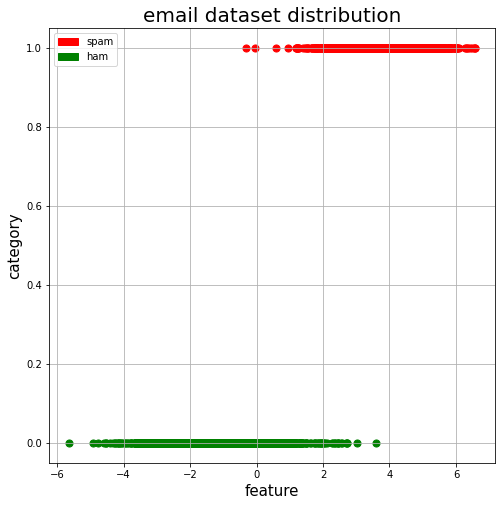

In [ ]:
import matplotlib.patches as mpatches

fig=plt.figure(figsize=(8,8))  
ax=fig.add_subplot(1,1,1)  
ax.set_xlabel('feature',fontsize = 15)  
ax.set_ylabel('category',fontsize = 15)  
ax.set_title('email dataset distribution',fontsize=20)  
targets=['spam','ham'] 
colors=['r','g']  
#for target,col in zip(y,colors):
#  ax.scatter(x_lda,y,
#            c=col,
#             s=50)
for num in range(5171):
  if y[num] == 0:
      ax.scatter(x_lda[num],y[num],
            c='green',
             s=50)
  if y[num] == 1:
      ax.scatter(x_lda[num],y[num],
            c='red',
             s=50)
red_patch = mpatches.Patch(color='red', label='spam')
blue_patch = mpatches.Patch(color='green', label='ham')

ax.legend(handles=[red_patch, blue_patch])
#ax.legend(targets)  
ax.grid()

# Test Email Classification

Spam and Ham class data distribution in Test set
Spam : 742 Ham : 293


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Email Class'),
 Text(0.5, 1.0, 'Test set classification')]

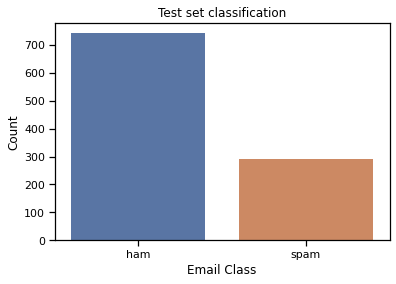

In [53]:
train, test = train_test_split(data, test_size = 0.2, random_state = 42)

print("Spam and Ham class data distribution in Test set")
label=['ham','spam']
values=[test['label_num'].value_counts()[0],test['label_num'].value_counts()[1]]
print('Spam : ' +str(values[0]) , 'Ham : ' +str(values[1]) )
ax = sns.barplot(x = label, y = values, data = test)
ax.set(xlabel="Email Class", ylabel = "Count", title='Test set classification')


## Divide the training and test set

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
Y= data['label'].values
X_train , X_test , Y_train , Y_test =train_test_split(data['text'], Y, test_size = 0.2, random_state = 42)
test_data = X_test
X_train=vectorizer.fit_transform(X_train)
X_test=vectorizer.transform(X_test)

In [55]:
print(test_data)
test_data.shape

1566    hpl nom march see attached file hplno xls hpln...
1988    online pharxmacy meds disscount phafrmacy onls...
1235    nom actual volume april th agree eileen ponton...
2868    meter dec robert put heads together decided en...
4903    coastal oil gas corporation melissa deal creat...
                              ...                        
1175    alert spam prevention cllck stop sign stop spa...
4476    enron blockbuster launch entertainment demand ...
4198    make computer like new remove spyware home com...
2689    temp forecast model xls file city temperature ...
2142    enron hpl actuals august teco tap enron hpl ga...
Name: text, Length: 1035, dtype: object


(1035,)

## Support Vector Machine Classifier

In [56]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.svm import SVC

clf = SVC(kernel='linear')
classifier = clf.fit(X_train , Y_train)

svm_y_pred_test=clf.predict(X_test)
svm_y_pred_train=clf.predict(X_train)
cm_svm_test=confusion_matrix(Y_test, svm_y_pred_test)
cm_svm_train = confusion_matrix(Y_train , svm_y_pred_train)
print(cm_svm_test)
print(cm_svm_train)
accuracy_score(Y_test , svm_y_pred_test)
print(classification_report(svm_y_pred_test, Y_test))


[[724  18]
 [ 15 278]]
[[2930    0]
 [   0 1206]]
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       739
        spam       0.95      0.94      0.94       296

    accuracy                           0.97      1035
   macro avg       0.96      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035



In [57]:
count=0

with open('/content/drive/MyDrive/mispredicted_emails_SVM.csv', mode='w') as analysis_file:
    writer = csv.writer(analysis_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['EMAIL TEXT', 'ACTUAL', 'PREDICTED'])
    for row_index, (input, prediction, label) in enumerate(zip (X_test, svm_y_pred_test, Y_test)):
      #print(row_index)
      if prediction != label:
        print('Row No : ', row_index, ' has been classified as ', prediction, 'and should be ', label)
        writer.writerow([test_data.iloc[row_index], label, prediction])
        count = count+1
print("\nTotal No of misclassified emails are: "+str(count))


Row No :  14  has been classified as  ham and should be  spam
Row No :  67  has been classified as  spam and should be  ham
Row No :  112  has been classified as  ham and should be  spam
Row No :  117  has been classified as  ham and should be  spam
Row No :  125  has been classified as  ham and should be  spam
Row No :  133  has been classified as  ham and should be  spam
Row No :  147  has been classified as  spam and should be  ham
Row No :  170  has been classified as  spam and should be  ham
Row No :  186  has been classified as  spam and should be  ham
Row No :  195  has been classified as  ham and should be  spam
Row No :  214  has been classified as  spam and should be  ham
Row No :  228  has been classified as  ham and should be  spam
Row No :  229  has been classified as  spam and should be  ham
Row No :  235  has been classified as  spam and should be  ham
Row No :  457  has been classified as  ham and should be  spam
Row No :  494  has been classified as  spam and should be

Confusion matrix, without normalization
[[724  18]
 [ 15 278]]
Normalized confusion matrix
[[0.97574124 0.02425876]
 [0.05119454 0.94880546]]


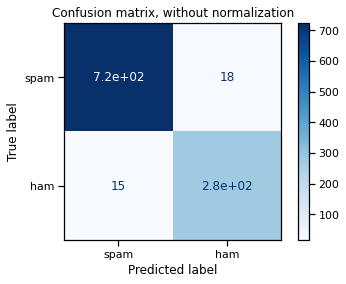

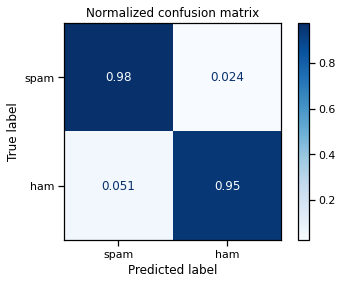

In [59]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
class_names = ["spam","ham"]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, Y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

## Naive Bayes Classifier

In [60]:
NB_classifier =MultinomialNB()
classifier_nb=NB_classifier.fit(X_train , Y_train)

Y_pred_train = NB_classifier.predict(X_train)
Y_pred_test = NB_classifier.predict(X_test)

cm_test = confusion_matrix(Y_test, Y_pred_test)
cm_train = confusion_matrix(Y_train , Y_pred_train)

accuracy_score(Y_test , Y_pred_test)
print(classification_report(Y_pred_test, Y_test))


              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       743
        spam       0.96      0.96      0.96       292

    accuracy                           0.98      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



In [61]:
count=0

with open('/content/drive/MyDrive/mispredicted_emails_NB.csv', mode='w') as analysis_file:
    writer = csv.writer(analysis_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['EMAIL TEXT', 'ACTUAL', 'PREDICTED'])
    for row_index, (input, prediction, label) in enumerate(zip (X_test, Y_pred_test, Y_test)):
      #print(row_index)
      if prediction != label:
        print('Row No : ', row_index, ' has been classified as ', prediction, 'and should be ', label)
        writer.writerow([test_data.iloc[row_index], label, prediction])
        count = count+1
        #print(test_data.iloc[row_index])
print("\nTotal No of misclassified emails are: "+str(count))


Row No :  53  has been classified as  ham and should be  spam
Row No :  125  has been classified as  ham and should be  spam
Row No :  133  has been classified as  ham and should be  spam
Row No :  147  has been classified as  spam and should be  ham
Row No :  165  has been classified as  ham and should be  spam
Row No :  229  has been classified as  spam and should be  ham
Row No :  243  has been classified as  ham and should be  spam
Row No :  253  has been classified as  spam and should be  ham
Row No :  358  has been classified as  ham and should be  spam
Row No :  431  has been classified as  spam and should be  ham
Row No :  498  has been classified as  ham and should be  spam
Row No :  540  has been classified as  spam and should be  ham
Row No :  555  has been classified as  spam and should be  ham
Row No :  561  has been classified as  spam and should be  ham
Row No :  655  has been classified as  spam and should be  ham
Row No :  669  has been classified as  ham and should be

Confusion matrix, without normalization
[[731  11]
 [ 12 281]]
Normalized confusion matrix
[[0.9851752  0.0148248 ]
 [0.04095563 0.95904437]]


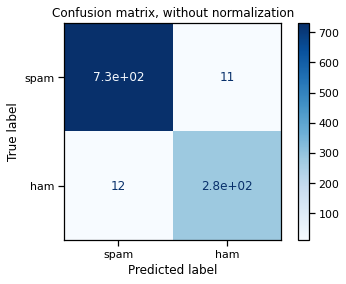

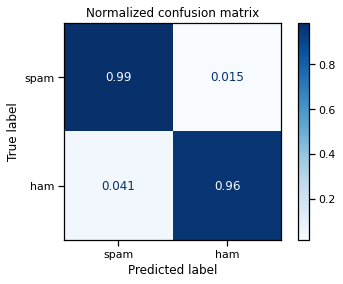

In [62]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
class_names = ["spam","ham"]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier_nb, X_test, Y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

#Save the model

In [63]:
import pickle
# save the model to drive
filename = '/content/drive/MyDrive/NB_spam_model.pkl'
pickle.dump(NB_classifier, open(filename, 'wb'))